In [1]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.models import Sequential

data_dir = "/home/saher/Documents/data_preprocessed_matlab"
file_names = [f"s{i:02d}.mat" for i in range(1, 33)] 

X_data = []
y_participant = []

for participant_id, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(data_dir, file_name)
    mat = scipy.io.loadmat(file_path)
    
    eeg_data = mat['data'] 
    
    for clip_id in range(40):
        clip_data = eeg_data[clip_id, :32, 384:]  
        
        for second in range(60):
            start_idx = second * 128
            end_idx = (second + 1) * 128
            second_data = clip_data[:, start_idx:end_idx]
            
            X_data.append(second_data)
            y_participant.append(participant_id - 1)  

X_data = np.array(X_data)
y_participant = np.array(y_participant)

participant_encoder = LabelEncoder()
y_participant_encoded = participant_encoder.fit_transform(y_participant)

y_participant_onehot = tf.keras.utils.to_categorical(y_participant_encoded, num_classes=len(participant_encoder.classes_))

scaler = StandardScaler()
X_data = X_data.reshape(-1, 32 * 128)  
X_data = scaler.fit_transform(X_data)
X_data = X_data.reshape(-1, 32, 128)  


2024-11-12 01:01:05.890190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 01:01:05.897257: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 01:01:05.952293: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 01:01:06.019790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 01:01:06.088781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

/home/saher/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-12 01:01:30.655533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2060 - loss: 3.0472 - val_accuracy: 0.8331 - val_loss: 1.2319
Epoch 2/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9116 - loss: 0.9279 - val_accuracy: 0.9499 - val_loss: 0.4508
Epoch 3/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9687 - loss: 0.3272 - val_accuracy: 0.9713 - val_loss: 0.2384
Epoch 4/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9845 - loss: 0.1644 - val_accuracy: 0.9774 - val_loss: 0.1601
Epoch 5/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9929 - loss: 0.0904 - val_accuracy: 0.9805 - val_loss: 0.1216
Epoch 6/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9941 - loss: 0.0632 - val_accuracy: 0.9807 - val_loss: 0.1023
Epoch 7/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9967 - loss: 0.0395 - val_accuracy: 0.9832 - val_loss: 0.0879
Epoch 8/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0269 - val_accu

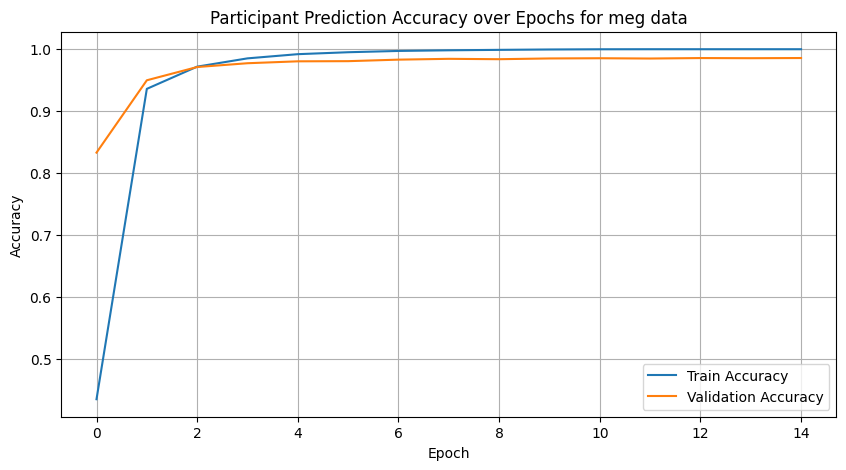

2040/2040 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


<Figure size 1200x800 with 0 Axes>

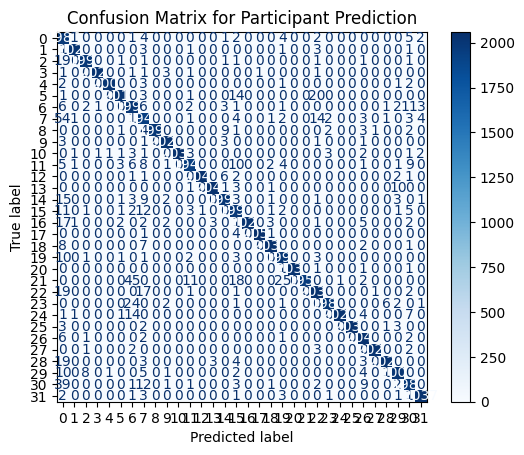

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_participant_onehot, test_size=0.85, random_state=42)

def create_participant_model():

    model = Sequential()    
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(32, 128)))
        
    model.add(Flatten())
    model.add(Dense(len(participant_encoder.classes_), activation='softmax'))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

model = create_participant_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, verbose=1)

scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Participant Prediction Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=participant_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Participant Prediction')
plt.show()
